# Oil price analysis

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
# Add the 'scripts' directory to the Python path for module imports
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Set max rows and columns to display
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Configure logging
from logger import SetupLogger
# Assuming this class is defined in scripts/
from pre_processor import DataPreprocessor
from visualizer import DataVisualizer

logger = SetupLogger(log_file='../logs/eda.log').get_logger()

# Set default figure size for all plots
plt.rcParams['figure.figsize'] = (14, 7)

**Data collection**

In [2]:
# Setup the data preprocessor class
processor = DataPreprocessor(logger=logger)
# Load the data
price_data = processor.load_data("../data/BrentOilPrices.csv")

In [3]:
# Explore the first 10 rows
price_data.head(10)

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
1987-05-27,18.60
1987-05-28,18.60
1987-05-29,18.58
1987-06-01,18.65


In [4]:
# Explore the last 10 rows
price_data.tail(10)

,Price
Date,
2022-11-01,95.12
2022-11-02,96.07
2022-11-03,95.29
2022-11-04,99.53
2022-11-07,99.87
2022-11-08,96.85
2022-11-09,93.05
2022-11-10,94.25
2022-11-11,96.37


**Data Cleaning and Preprocessing**

In [5]:
processor.inspect(price_data)

Dimensions (rows, columns): (9011, 2)

Data Types:
Date     datetime64[ns]
Price           float64
dtype: object

No missing values found.

Unique Values in Each Column:
Date     9011
Price    5015
dtype: int64
Number of duplicate rows: 0

Summary Statistics for Numeric Columns:


,Price
count,9011.000000
mean,48.420782
std,32.860110
min,9.100000
25%,19.050000
50%,38.570000
75%,70.090000
max,143.950000


In [6]:
# Create instances of the DataVisualizer class
visualizer = DataVisualizer(price_data, logger = logger)

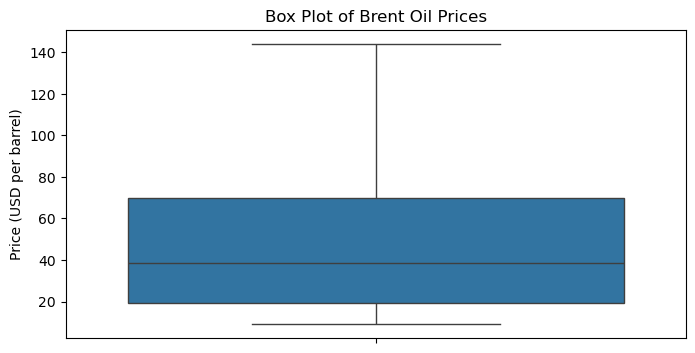

In [7]:
visualizer.plot_box()

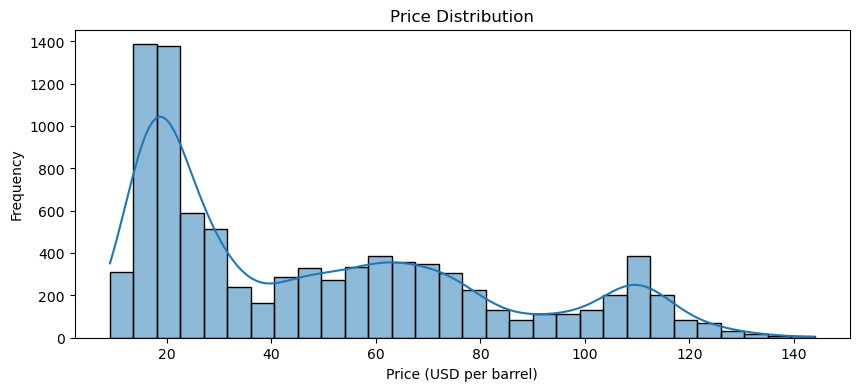

In [8]:
# Visualize the price distribution
visualizer.plot_price_distribution()

**Time Series analysis**

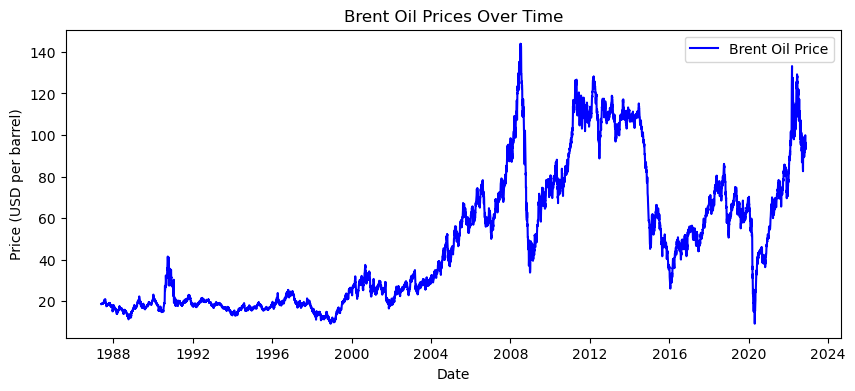

In [9]:
visualizer.plot_price_over_time()

**Seasonality Analysis**

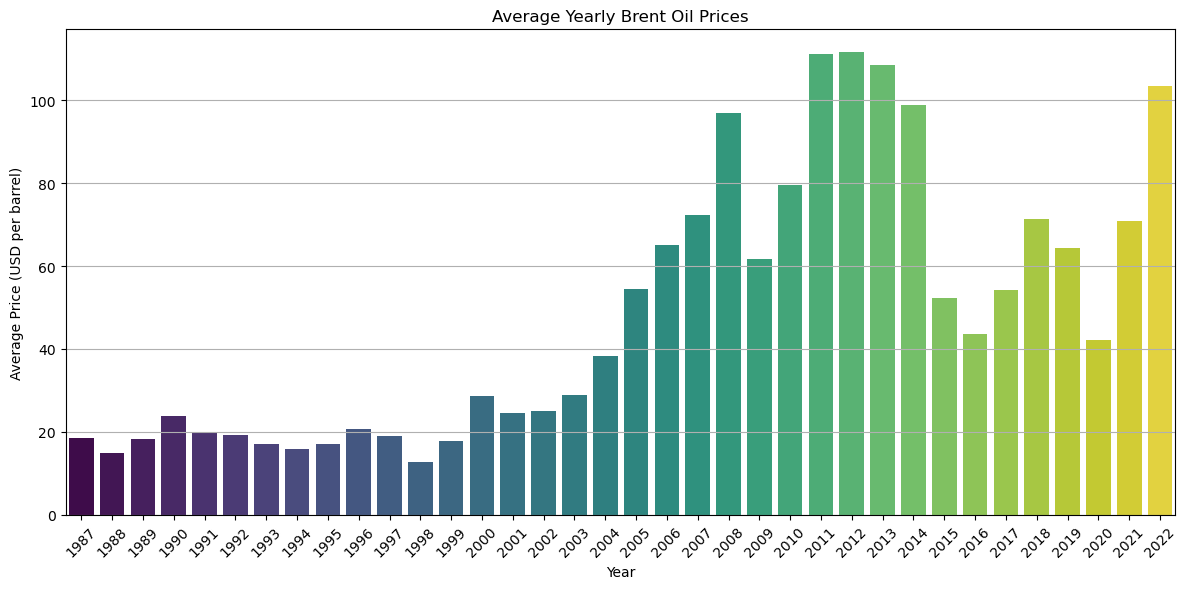

In [10]:
visualizer.plot_yearly_average()

**Rolling volatility analysis**

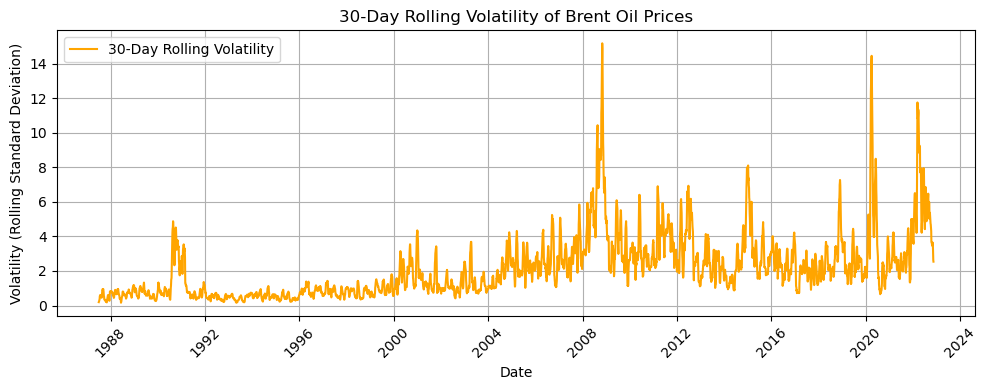

In [11]:
# 30-Day Volatile
visualizer.plot_rolling_volatility(30)

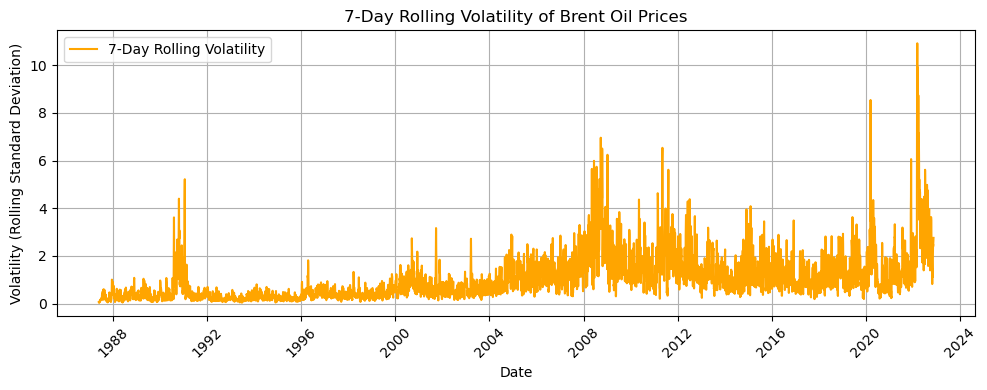

In [12]:
# 7-Day volatile
visualizer.plot_rolling_volatility(7)

**Seasonal decomposition**

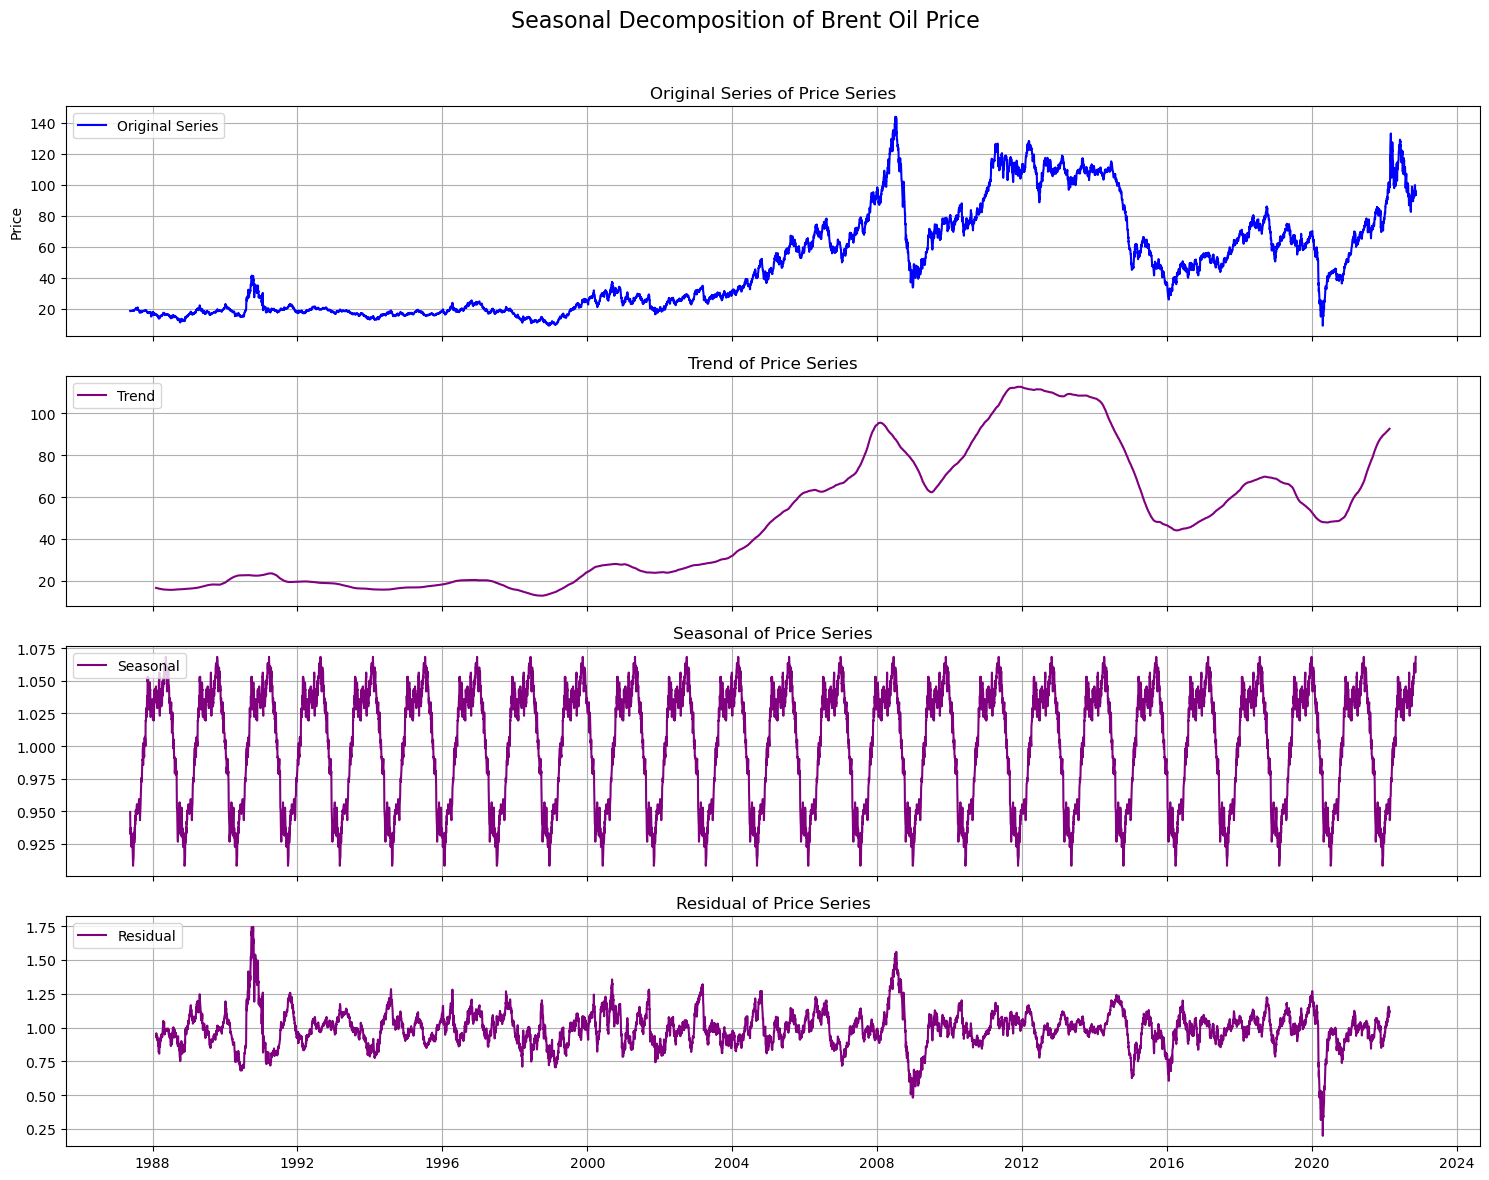

In [13]:
# Apply seasonal decomposition (use model='multiplicative' for data with proportional seasonal effects)
result = seasonal_decompose(price_data['Price'], model='multiplicative', period=365)  # Adjust period if necessary

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
components = ['Original Series', 'Trend', 'Seasonal', 'Residual']
series = [price_data['Price'], result.trend, result.seasonal, result.resid]

for ax, comp, ser in zip(axes, components, series):
    ax.plot(price_data.index, ser, label=comp, color='b' if comp == 'Original Series' else 'purple')
    ax.set_title(f'{comp} of Price Series')
    ax.set_ylabel('Price' if comp == 'Original Series' else '')
    ax.grid(True)
    ax.legend(loc='upper left')

# Improve layout and display the plot
fig.suptitle('Seasonal Decomposition of Brent Oil Price', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the main title
plt.show()

**Stationaly Analysis of Time Series Data**

ADF Statistic: -11.250179655838958
p-value: 1.7197844570683866e-20
Critical Values:
   1%: -3.431079878822629
   5%: -2.8618625589084705
   10%: -2.566941693085751
The ADF test suggests the series is stationary.


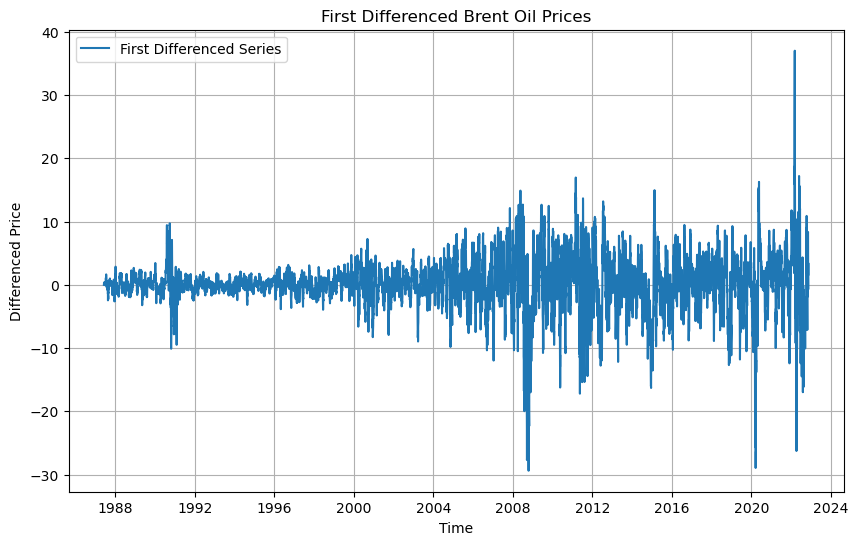

(-11.250179655838958, 1.7197844570683866e-20)

In [14]:
def test_stationarity(series, title, label, alpha=0.05):
    adf_result = adfuller(series)
    
    # Print ADF results
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'   {key}: {value}')
    
    # Interpretation
    if adf_result[1] < alpha:
        print("The ADF test suggests the series is stationary.")
    else:
        print("The ADF test suggests the series is not stationary.")

    # Plot the differenced series
    plt.figure(figsize=(10, 6))
    plt.plot(series, label=label)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Differenced Price')
    plt.legend()
    plt.grid()
    plt.show()
    
    return adf_result[0], adf_result[1]  # Returning ADF statistic and p-value for further use

# Assuming 'price_data' is your DataFrame with a 'Price' column
data = price_data['Price']

# First differencing
data_diff = data.diff(12).dropna()
test_stationarity(data_diff, title='First Differenced Brent Oil Prices', label='First Differenced Series')

ADF Statistic: -16.427113494485877
p-value: 2.4985801611429968e-29
Critical Values:
   1%: -3.4310783342658615
   5%: -2.861861876398633
   10%: -2.566941329781918
The ADF test suggests the series is stationary.


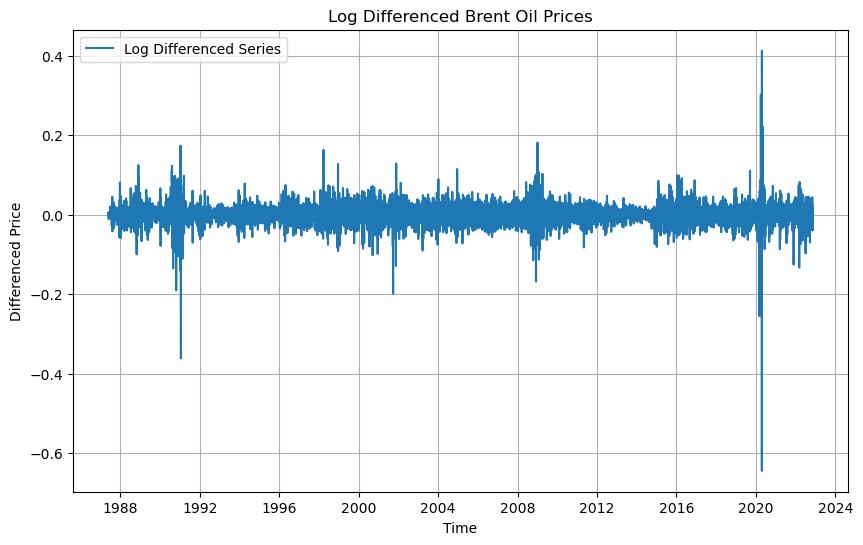

(-16.427113494485877, 2.4985801611429968e-29)

In [15]:
# Log transformation
log_data = np.log(price_data['Price'])
log_data_diff = log_data.diff().dropna()
test_stationarity(log_data_diff, title='Log Differenced Brent Oil Prices', label='Log Differenced Series')